In [2]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
plt.rcParams['image.cmap'] = 'gist_earth'

In [5]:
import sys
print('\n'.join(sys.path))

import site
print('site is located at: ',site.__file__)


/home/yfantaye/anaconda3/envs/py27/lib/python27.zip
/home/yfantaye/anaconda3/envs/py27/lib/python2.7
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/plat-linux2
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/lib-tk
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/lib-old
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/lib-dynload
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/hide-0.1.0-py2.7.egg
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/seek-0.1.0-py2.7.egg
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tf_unet-0.1.0-py2.7.egg
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/extensions
/data/home/yfantaye/.ipython
site is located at:  /home/yfantaye/anaconda3/envs/py27/l

## preparing training data
only one day...

In [4]:
# !wget -q -r -nH -nc -np --cut-dirs=2 http://people.phys.ethz.ch/~ast/cosmo/bgs_example_data/

In [2]:
!mkdir -p bgs_example_data/seek_cache

In [9]:
# !seek --file-prefix='./bgs_example_data' --map-name='BGS_maps.hdf' --verbose=True seek.config.process_survey_fft

In [10]:
# !seek --file-prefix='./bgs_example_data' --post-processing-prefix='bgs_example_data/seek_cache' \
#               --chi-1=20 --overwrite=True seek.config.process_survey_fft

== Ivy run took:  84.976 s ===
Traversing file system        :   0.007s
Generate gain files           :   0.006s
Initialize                    :   0.000s
Load data                     :  12.021s
Convert TOD                   :   0.029s
Process coordinates           :   0.788s
Masking objects               :   1.152s
Masking artefacts             :   0.002s
Remove RFI                    :  24.772s
postprocessing TOD            :   0.071s
remove background baseline    :   0.498s
Restructure TOD               :   0.730s
ParallelPluginCollection      :  40.074s
Create maps                   :   2.162s
ParallelPluginCollection      :   2.256s
Write maps                    :   0.408s


## setting up the unet

In [3]:
from unet_scripts.radio_util import DataProvider
from tf_unet import unet

In [4]:
files = glob.glob('bgs_example_data/seek_cache/*')

In [6]:
data_provider = DataProvider(600, files)

net = unet.Unet(channels=data_provider.channels, 
                n_class=data_provider.n_class, 
                layers=3, 
                features_root=64,
                cost_kwargs=dict(regularizer=0.001),
                )

trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

2017-07-07 12:29:29,106 Layers 3, features 64, filter size 3x3, pool size: 2x2


Number of files used: 1


In [9]:
unet.Unet?

In [4]:
#visualise raw, hdf5 files
#d1,l1=data_provider._next_data()
#d2,l2=data_provider._next_data()
fname='bgs_example_data/2016/03/21/HIMap_RSG7M_A1_24_MP_PXX_Z0_C0-M9703A_DPUA_20160321_111403.h5'
import h5py
f5=h5py.File(files[0], "r")


In [6]:
files

['bgs_example_data/seek_cache/HIMap_RSG7M_A1_24_MP_PXX_Z0_C0-M9703A_DPUA_20160321_000000.h5']

In [5]:
#nx = f5["data"].shape
f5.items()
#f5.close()

[(u'data', <HDF5 dataset "data": shape (276, 14006), type "<f8">),
 (u'dec', <HDF5 dataset "dec": shape (14006,), type "<f8">),
 (u'frequencies', <HDF5 dataset "frequencies": shape (276,), type "<f8">),
 (u'mask', <HDF5 dataset "mask": shape (276, 14006), type "|b1">),
 (u'ra', <HDF5 dataset "ra": shape (14006,), type "<f8">),
 (u'ref_channel', <HDF5 dataset "ref_channel": shape (14006,), type "<f8">),
 (u'time', <HDF5 dataset "time": shape (14006,), type "<f8">)]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].imshow(d1,aspect="auto")
a=ax[1].imshow(l1,aspect="auto")
plt.colorbar(a)

In [26]:
32*600

19200

## training the network
only one epoch. For good results many more are neccessary

In [10]:
path = trainer.train(data_provider, "./unet_trained_bgs_example_data", 
                     training_iters=32, 
                     epochs=1, 
                     dropout=0.5, 
                     display_step=2)



2017-07-07 12:30:33,693 Removing '/data/home/yfantaye/SETI/tf_unet/demo/prediction'
2017-07-07 12:30:33,713 Removing '/data/home/yfantaye/SETI/tf_unet/demo/unet_trained_bgs_example_data'
2017-07-07 12:30:33,721 Allocating '/data/home/yfantaye/SETI/tf_unet/demo/prediction'
2017-07-07 12:30:33,722 Allocating '/data/home/yfantaye/SETI/tf_unet/demo/unet_trained_bgs_example_data'
2017-07-07 12:30:41,114 Verification error= 36.2%, loss= 1.4038
2017-07-07 12:30:44,573 Start optimization
2017-07-07 12:30:47,955 Iter 0, Minibatch Loss= 1.4191, Training Accuracy= 0.4845, Minibatch error= 51.5%
2017-07-07 12:30:49,459 Iter 2, Minibatch Loss= 1.4296, Training Accuracy= 0.3861, Minibatch error= 61.4%
2017-07-07 12:30:51,023 Iter 4, Minibatch Loss= 1.3695, Training Accuracy= 0.6991, Minibatch error= 30.1%
2017-07-07 12:30:52,585 Iter 6, Minibatch Loss= 1.3580, Training Accuracy= 0.6812, Minibatch error= 31.9%
2017-07-07 12:30:54,164 Iter 8, Minibatch Loss= 1.2908, Training Accuracy= 0.7509, Minibatc

In [11]:
print(path)
#path='./unet_trained_bgs_example_data/model.cpkt'

./unet_trained_bgs_example_data/model.cpkt


## running the prediction on the trained unet

In [27]:
data_provider = DataProvider(10000, files)
x_test, y_test = data_provider(1)
prediction = net.predict(path, x_test)

Number of files used: 1
INFO:tensorflow:Restoring parameters from ./unet_trained_bgs_example_data/model.cpkt


2017-07-07 13:09:47,838 Restoring parameters from ./unet_trained_bgs_example_data/model.cpkt
2017-07-07 13:09:48,070 Model restored from file: ./unet_trained_bgs_example_data/model.cpkt


In [ ]:
print('orig shape: ',x_test.shape)
print('orig label shape: ',y_test.shape)
print('predict shape',prediction.shape)
unet.util.plot_prediction(x_test[0,...,0], y_test[0,...,1], prediction[0,...,1])

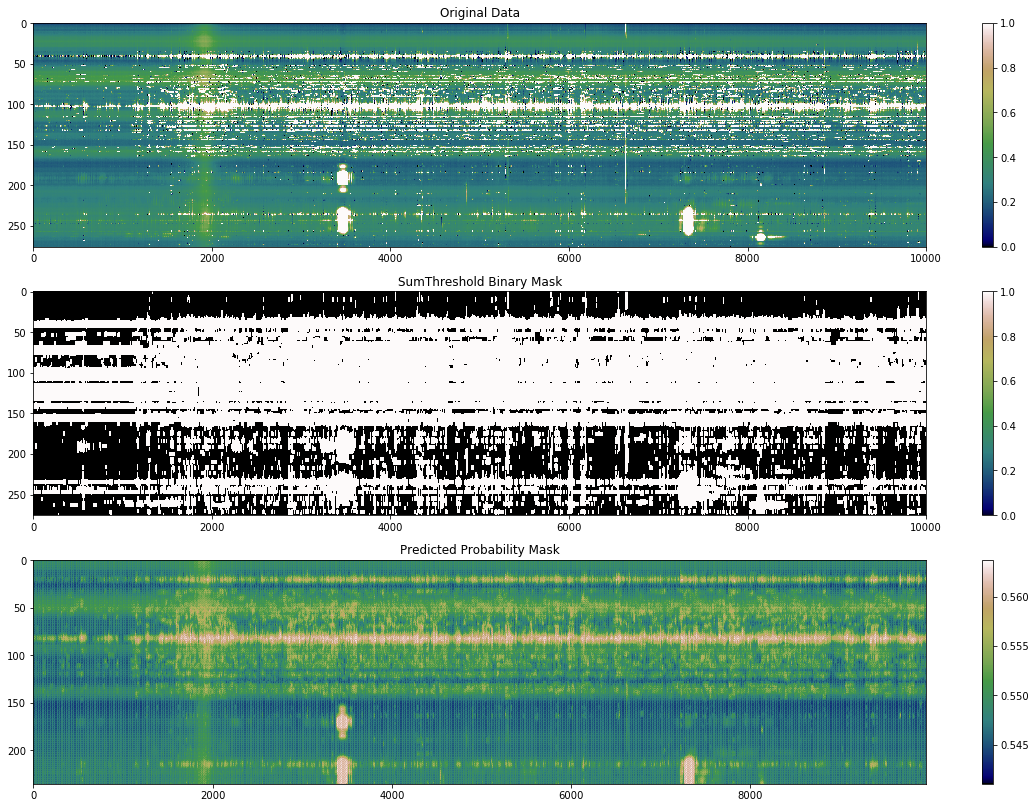

In [23]:
fig, ax = plt.subplots(3,1, figsize=(20,14))
img=ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[0].set_title('Original Data')
plt.colorbar(img,ax=ax[0])

img=ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[1].set_title('SumThreshold Binary Mask')
plt.colorbar(img,ax=ax[1])

img=ax[2].imshow(prediction[0,...,1]>0.5, aspect="auto")
ax[2].set_title('Predicted Probability Mask')
plt.colorbar(img,ax=ax[2])

AttributeError: 'int' object has no attribute 'get_figure'

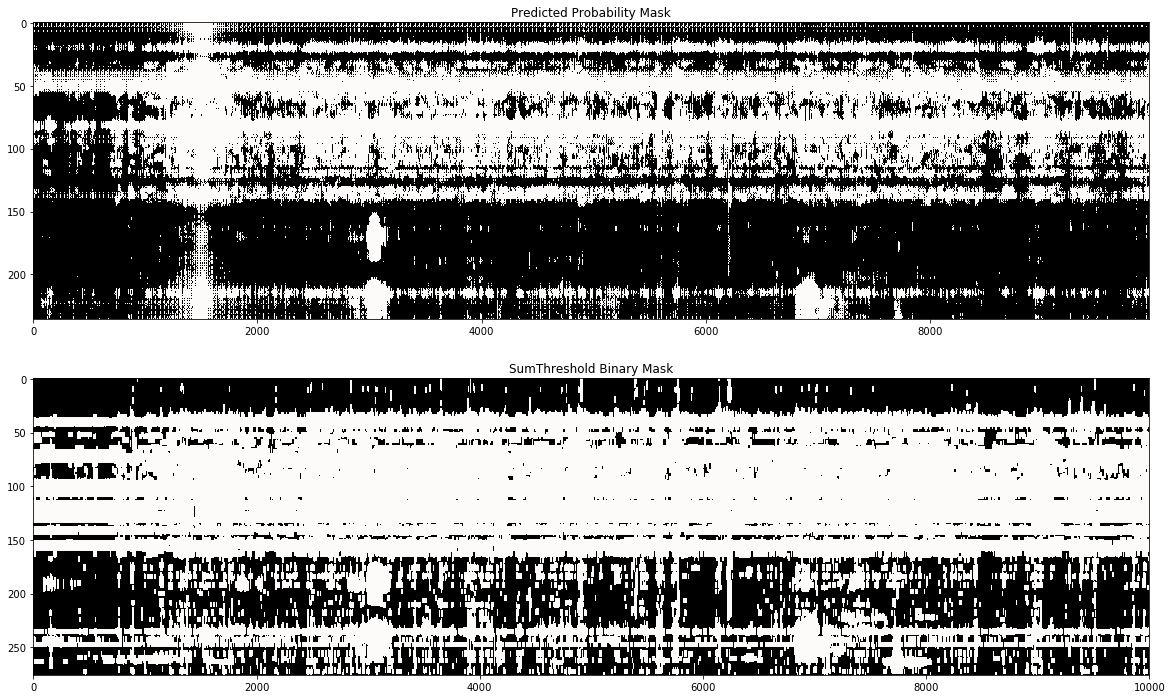

In [42]:
fig, axx = plt.subplots(2,1,figsize=(20,12))
ax1=axx[0]
ax2=axx[1]
pp=prediction[0,...,1].copy()
pp[pp>pp.mean()]=1.0
pp[pp<pp.mean()]=0.0
img=ax1.imshow(pp, aspect="auto")
ax1.set_title('Predicted Probability Mask')

img=ax2.imshow(y_test[0,...,1], aspect="auto")
ax2.set_title('SumThreshold Binary Mask')
plt.colorbar(img,ax=2)
#plt.colorbar(img,ax=ax1)

In [37]:
print(prediction[0,...,1].copy().min(),prediction[0,...,1].copy().mean())

0.541056 0.549602
